In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.6 MB/s eta 0:00:00
Mounted at /content/gdrive


In this notebook i am going to implement methods concerning using fastai mid-API for customised process of preparing data for training shown in 11th chapter of the fastbook with addition of training the model.

Load the images paths

In [2]:
path = untar_data(URLs.PETS)/'images'
files = get_image_files(path)

Class responsible for displaying pictures along with their class

In [3]:
class PetImage(fastuple):
    def show(self, ctx=None, **kwargs):
        if len(self) > 1:
            img, is_cat = self
        else:
            img = self[0]
            is_cat = 'Undetermined'

        if not isinstance(img, Tensor):
            t = tensor(img)
            t = t.permute(2,0,1)
        else:
            t = img

        return show_image(t, title=is_cat, ctx=ctx, **kwargs)

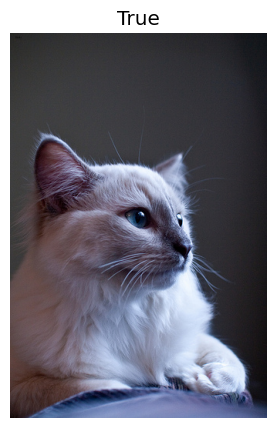

In [4]:
img = PILImage.create(files[0])
s = PetImage(img, True)
s.show();

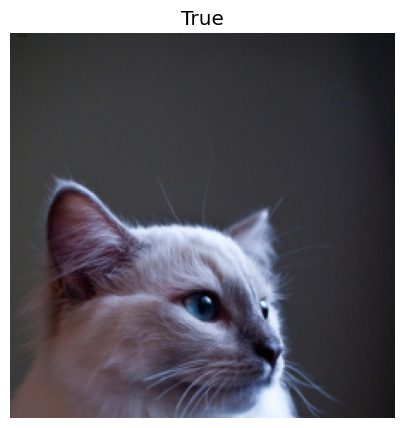

In [5]:
s1 = Resize(224)(s)
s1.show();

In [6]:
def is_cat(x):
    return x.name[0].isupper()

A Transform class that splits pictures into training and validation datasets, with encodes method that defines how pictures will be passed to the model

In [7]:
class PetTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self.label_func(f) for f in files[splits[1]]}


    def encodes(self, f):
        t = self.valid.get(f, self.label_func(f))
        img = PILImage.create(f)
        return PetImage(img, t)

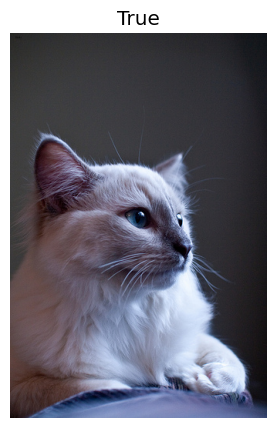

In [8]:
splits = RandomSplitter()(files)
tfm = PetTransform(files, is_cat, splits)
tfm(files[0]).show();

A step necessary for creating dataloaders

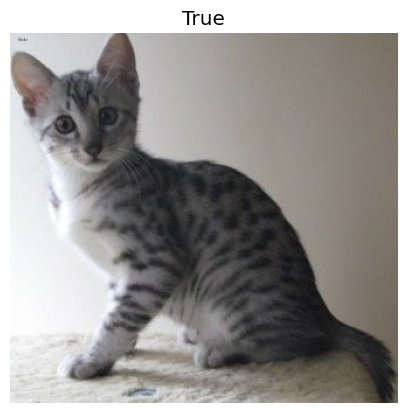

In [9]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0);

tuning the behaviour of show_batch so that it will work with my dataloaders

In [10]:
@typedispatch
def show_batch(x:PetImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=3, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*3, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i, ctx in enumerate(ctxs):
        PetImage(x[0][i], ['Dog', 'Cat'][x[1][i].item()]).show(ctx=ctx)

dataloaders with additional transforms required for the model to work

In [11]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

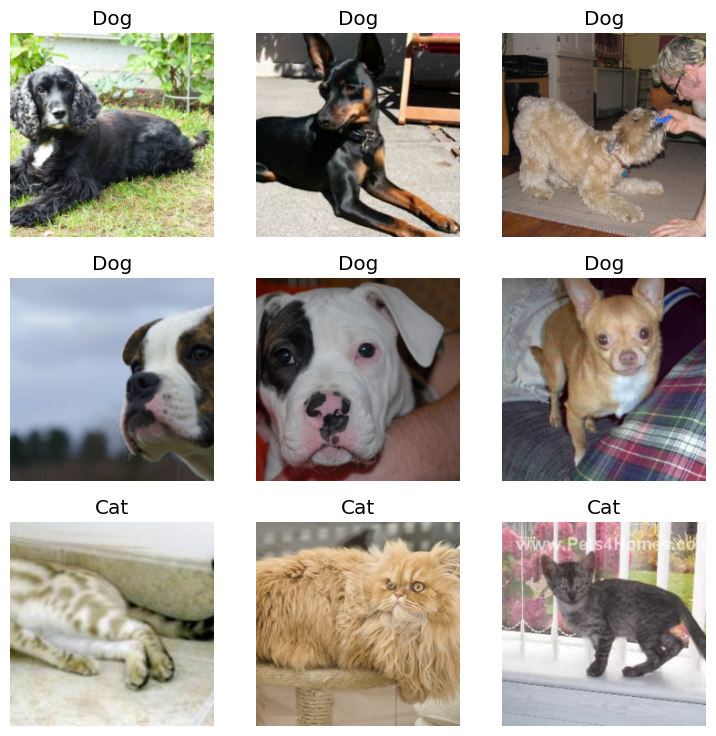

In [12]:
dls.show_batch()

from here goes the part with preparation and training of neural net

In [13]:
class PetModel(Module):
    def __init__(self, encoder, head):
        self.encoder, self.head = encoder, head


    def forward(self, x):
        ftrs = self.encoder(x)
        return self.head(ftrs)

In [14]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
 'weights': 'DEFAULT'}

In [15]:
encoder = create_body(resnet34(pretrained=True), cut=-2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 101MB/s] 


In [16]:
encoder[-1]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [17]:
head = create_head(512, 2, ps=0.5)
model = PetModel(encoder, head)

In [18]:
def pet_splitter(model):
    return [params(model.encoder), params(model.head)]

In [19]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

Let's check if validation and training datasets are disjoint

In [20]:
valids = [k for k, v in tfm.valid.items()]
assert not [v for v in valids if v in files[splits[0]]]

With method of trial and error I have found out that training freezed model for 4 epochs and for 3 epochs after unfreezing works out pretty well

In [21]:
learn = Learner(dls, model, loss_func=loss_func, splitter=pet_splitter, metrics=accuracy)
learn.freeze()

SuggestedLRs(valley=0.0003311311302240938)

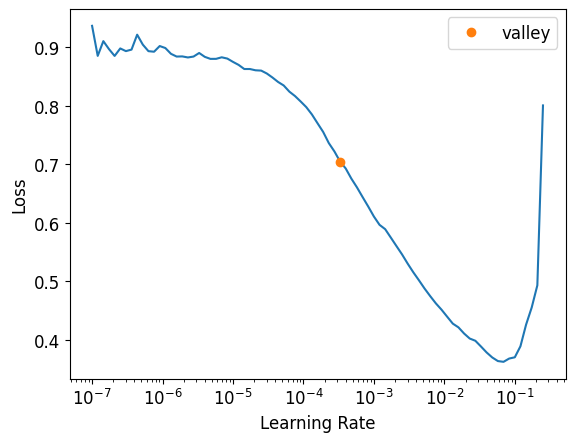

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(4, 6e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.060130,0.040487,0.985792,00:48
1,0.075827,0.079823,0.974290,00:49
2,0.057190,0.025084,0.993234,00:49
3,0.020582,0.018722,0.993911,00:48


In [24]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(5e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.018441,0.048320,0.988498,00:52
1,0.015993,0.029964,0.991204,00:50
2,0.012887,0.022274,0.992558,00:52


In [25]:
@typedispatch
def show_results(x:PetImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=3, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*3, max_n//ncols * 3.5)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i, ctx in enumerate(ctxs):
        title = f'Actual: {["Dog", "Cat"][x[1][i].item()]} \n Prediction: {["Dog", "Cat"][torch.argmax(y[1][i])]}'
        PetImage(x[0][i], title).show(ctx=ctx)

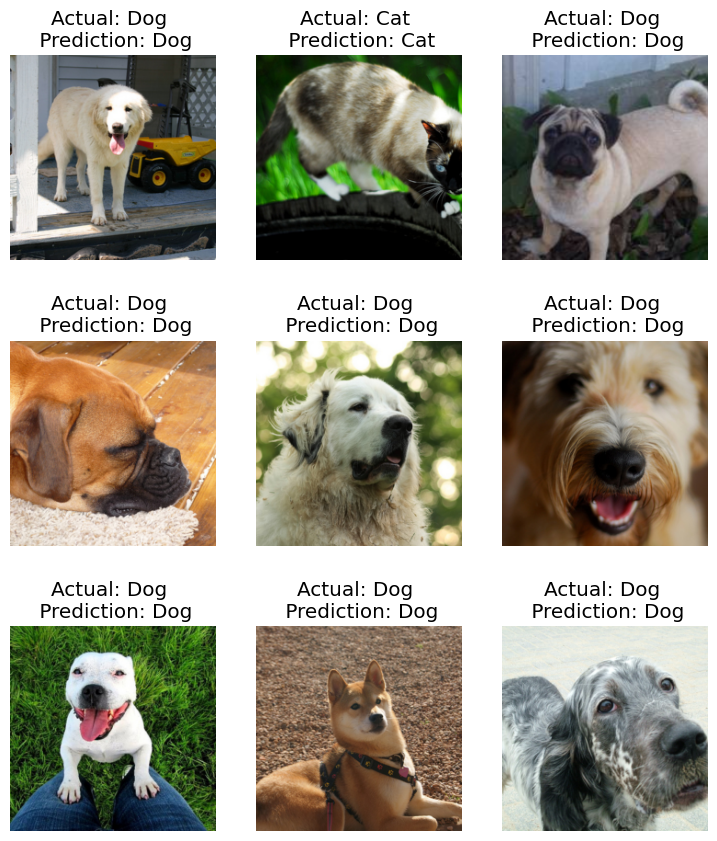

In [26]:
learn.show_results()

In [30]:
@patch
def petpredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    if torch.argmax(res[0]) == tensor(0):
        PetImage(item[0], 'Prediction: Dog').show()
    else:
        PetImage(item[0], 'Prediction: Cat').show()

    return res

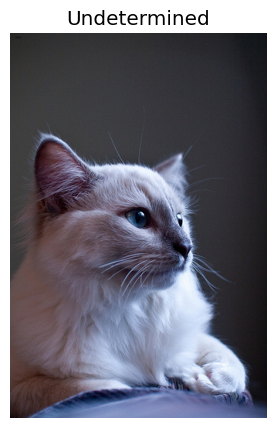

In [28]:
imgtest = PILImage.create(files[0])
petest = PetImage(imgtest)
petest.show();

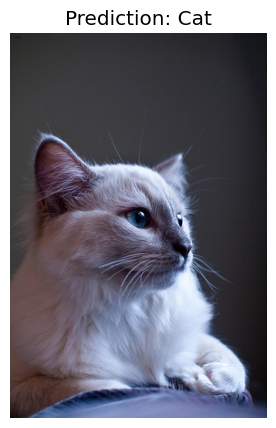

In [31]:
res = learn.petpredict(petest)